# Otto商品分类——Logistic 回归
log特征

我们以Kaggle 2015年举办的Otto Group Product Classification Challenge竞赛数据为例，分别调用缺省参数LogisticRegression、LogisticRegression + GridSearchCV以及LogisticRegressionCV进行参数调优。实际应用中LogisticRegression + GridSearchCV或LogisticRegressionCV任选一个即可。

Otto数据集是著名电商Otto提供的一个多类商品分类问题，类别数=9. 每个样本有93维数值型特征（整数，表示某种事件发生的次数，已经进行过脱敏处理）。 竞赛官网：https://www.kaggle.com/c/otto-group-product-classification-challenge/data


第一名：https://www.kaggle.com/c/otto-group-product-classification-challenge/discussion/14335
第二名：http://blog.kaggle.com/2015/06/09/otto-product-classification-winners-interview-2nd-place-alexander-guschin/

In [1]:
# 首先 import 必要的模块
import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

## 读取数据 & 数据探索

In [2]:
# 读取数据
# 请自行在log(x+1)特征和tf_idf特征上尝试，并比较不同特征的结果，
# path to where the data lies
dpath = './data/'
train = pd.read_csv(dpath +"Otto_FE_train_log.csv")
train.head()

,id,feat_1_log,feat_2_log,feat_3_log,feat_4_log,feat_5_log,feat_6_log,feat_7_log,feat_8_log,feat_9_log,...,feat_85_log,feat_86_log,feat_87_log,feat_88_log,feat_89_log,feat_90_log,feat_91_log,feat_92_log,feat_93_log,target
0,1,0.167949,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.172195,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,Class_1
1,2,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.159571,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,Class_1
2,3,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.159571,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,Class_1
3,4,0.167949,0.0,0.0,0.162608,0.649561,0.289065,0.489076,0.000000,0.0,...,0.000000,0.165443,0.260365,0.0,0.0,0.000000,0.0,0.0,0.0,Class_1
4,5,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.172195,0.000000,0.000000,0.0,0.0,0.142178,0.0,0.0,0.0,Class_1


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61878 entries, 0 to 61877
Data columns (total 95 columns):
id             61878 non-null int64
feat_1_log     61878 non-null float64
feat_2_log     61878 non-null float64
feat_3_log     61878 non-null float64
feat_4_log     61878 non-null float64
feat_5_log     61878 non-null float64
feat_6_log     61878 non-null float64
feat_7_log     61878 non-null float64
feat_8_log     61878 non-null float64
feat_9_log     61878 non-null float64
feat_10_log    61878 non-null float64
feat_11_log    61878 non-null float64
feat_12_log    61878 non-null float64
feat_13_log    61878 non-null float64
feat_14_log    61878 non-null float64
feat_15_log    61878 non-null float64
feat_16_log    61878 non-null float64
feat_17_log    61878 non-null float64
feat_18_log    61878 non-null float64
feat_19_log    61878 non-null float64
feat_20_log    61878 non-null float64
feat_21_log    61878 non-null float64
feat_22_log    61878 non-null float64
feat_23_log    6187

## 准备数据

In [4]:
y_train = train['target']   
X_train = train.drop(["id", "target"], axis=1)

#保存特征名字以备后用（可视化）
feat_names = X_train.columns 

#sklearn的学习器大多之一稀疏数据输入，模型训练会快很多
#查看一个学习器是否支持稀疏数据，可以看fit函数是否支持: X: {array-like, sparse matrix}.
#可自行用timeit比较稠密数据和稀疏数据的训练时间
from scipy.sparse import csr_matrix
X_train = csr_matrix(X_train)

## 默认参数的Logistic Regression

In [5]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [8]:
# 交叉验证用于评估模型性能和进行参数调优（模型选择）
#分类任务中交叉验证缺省是采用StratifiedKFold
#数据集比较大，采用3折交叉验证
from sklearn.model_selection import cross_val_score
loss = cross_val_score(lr, X_train, y_train, cv=3, scoring='neg_log_loss')
#%timeit loss_sparse = cross_val_score(lr, X_train_sparse, y_train, cv=3, scoring='neg_log_loss')
print ('logloss of each fold is: ',-loss)
print ('cv logloss is:', -loss.mean

logloss of each fold is:  [ 0.68515708  0.6861802   0.68082293]
cv logloss is: 0.684053401541


结果果然比用原始特征（0.797465616286）好很多

### 正则化的 Logistic Regression及参数调优

logistic回归的需要调整超参数有：C（正则系数，一般在log域（取log后的值）均匀设置候选参数）和正则函数penalty（L2/L1） 
目标函数为：J =  C* sum(logloss(f(xi), yi)) +* penalty 

在sklearn框架下，不同学习器的参数调整步骤相同：
设置参数搜索范围
生成GridSearchCV的实例（参数）
调用GridSearchCV的fit方法

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

#需要调优的参数
# 请尝试将L1正则和L2正则分开，并配合合适的优化求解算法（slover）
#tuned_parameters = {'penalty':['l1','l2'],
#                   'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
#                   }
penaltys = ['l1','l2']
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
tuned_parameters = dict(penalty = penaltys, C = Cs)

lr_penalty= LogisticRegression()
grid= GridSearchCV(lr_penalty, tuned_parameters,cv=3, scoring='neg_log_loss')
grid.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [9]:
# examine the best model
print(-grid.best_score_)
print(grid.best_params_)

0.67736990448
{'penalty': 'l2', 'C': 100}


最佳值在候选参数的边缘，再尝试更大的候选参数，直到找到拐点。

/Users/qing/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/qing/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


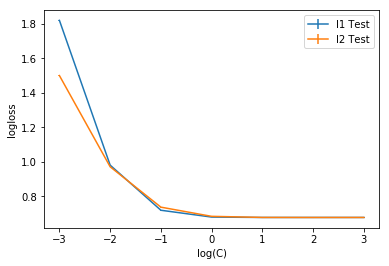

In [10]:
#pd.DataFrame(grid.cv_results_).to_csv('LogisticGridSearchCV_Otto.csv')
#cvresult = pd.DataFrame.from_csv('LogisticGridSearchCV_Otto.csv')
#test_means = cv_results['mean_test_score']
#test_stds = cv_results['std_test_score'] 
#train_means = cvresult['mean_train_score']
#train_stds = cvresult['std_train_score'] 


# plot CV误差曲线
test_means = grid.cv_results_[ 'mean_test_score' ]
test_stds = grid.cv_results_[ 'std_test_score' ]
train_means = grid.cv_results_[ 'mean_train_score' ]
train_stds = grid.cv_results_[ 'std_train_score' ]


# plot results
n_Cs = len(Cs)
number_penaltys = len(penaltys)
test_scores = np.array(test_means).reshape(n_Cs,number_penaltys)
train_scores = np.array(train_means).reshape(n_Cs,number_penaltys)
test_stds = np.array(test_stds).reshape(n_Cs,number_penaltys)
train_stds = np.array(train_stds).reshape(n_Cs,number_penaltys)

x_axis = np.log10(Cs)
for i, value in enumerate(penaltys):
    #pyplot.plot(log(Cs), test_scores[i], label= 'penalty:'   + str(value))
    plt.errorbar(x_axis, -test_scores[:,i], yerr=test_stds[:,i] ,label = penaltys[i] +' Test')
    #plt.errorbar(x_axis, -train_scores[:,i], yerr=train_stds[:,i] ,label = penaltys[i] +' Train')
    
plt.legend()
plt.xlabel( 'log(C)' )                                                                                                      
plt.ylabel( 'logloss' )
plt.savefig('LogisticGridSearchCV_C.png' )

plt.show()

上图给出了L1正则和L2正则下、不同正则参数C对应的模型在训练集上测试集上的logloss。可以看出在训练集上C越大（正则越少）的模型性能越好；但在测试集上当C=100时性能最好（L1正则）

### 用LogisticRegressionCV实现正则化的 Logistic Regression

### L1正则

In [13]:
from sklearn.linear_model import LogisticRegressionCV

Cs = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
#nCs = 9  #Cs values are chosen in a logarithmic scale between 1e-4 and 1e4.

# 大量样本（6W+）、高维度（93），L1正则 --> 可选用saga优化求解器(0.19版本新功能)
# LogisticRegressionCV比GridSearchCV快
lrcv_L1 = LogisticRegressionCV(Cs=Cs, cv = 3, scoring='neg_log_loss', penalty='l1', solver='liblinear', multi_class='ovr')
lrcv_L1.fit(X_train, y_train)    

LogisticRegressionCV(Cs=[0.001, 0.01, 0.1, 1, 10, 100, 1000],
           class_weight=None, cv=3, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l1', random_state=None, refit=True,
           scoring='neg_log_loss', solver='liblinear', tol=0.0001,
           verbose=0)

In [14]:
lrcv_L1.scores_

{'Class_1': array([[-0.14540941, -0.13888327, -0.11033725, -0.08749023, -0.08507874,
         -0.08521415, -0.08524412],
        [-0.14541674, -0.13889324, -0.11085722, -0.08637617, -0.0836447 ,
         -0.08395953, -0.08400906],
        [-0.14542407, -0.1389033 , -0.10961539, -0.08513374, -0.08210621,
         -0.08207292, -0.08208421]]),
 'Class_2': array([[-0.57507308, -0.45068348, -0.34931526, -0.32030421, -0.31669393,
         -0.31659969, -0.31659842],
        [-0.5750947 , -0.45161968, -0.34949774, -0.32071066, -0.31833695,
         -0.31854972, -0.31858148],
        [-0.57511632, -0.44816622, -0.34621376, -0.31954067, -0.31724365,
         -0.31728877, -0.31729992]]),
 'Class_3': array([[-0.38749796, -0.34550656, -0.28295377, -0.26357786, -0.26132108,
         -0.26135071, -0.26136374],
        [-0.38751797, -0.34476714, -0.2853468 , -0.26844802, -0.2666547 ,
         -0.26663302, -0.26663829],
        [-0.38753799, -0.345958  , -0.28507455, -0.26546101, -0.26289776,
         

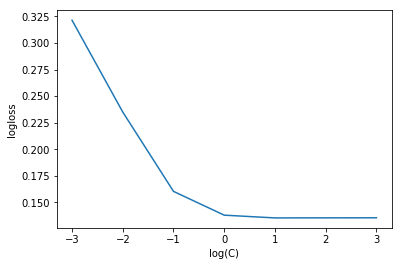

In [22]:
# scores_：dict with classes as the keys, and the values as the grid of scores obtained during cross-validating each fold,
# Each dict value has shape (n_folds, len(Cs))
Cs = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
n_Cs = len(Cs)
n_classes = 9
scores =  np.zeros((n_classes,n_Cs))

for j in range(n_classes):
        scores[j][:] = np.mean(lrcv_L1.scores_['Class_'+ str(j+1)],axis = 0)
    
mse_mean = -np.mean(scores, axis = 0)
plt.plot(np.log10(Cs), mse_mean.reshape(n_Cs,1)) 
#plt(np.log10(reg.Cs)*np.ones(3), [0.28, 0.29, 0.30])
plt.xlabel('log(C)')
plt.ylabel('logloss')
plt.show()

#print ('C is:',lr_cv.C_)  #对多类分类问题，每个类别的分类器有一个C


In [23]:
mse_mean

array([ 0.32140535,  0.23499902,  0.16034243,  0.13795419,  0.13536477,
        0.13543209,  0.13548341])

这个score似乎和GridSearchCV得到的Score不一样:(

In [24]:
best_C = np.argmin(mse_mean)
best_score = np.min(mse_mean)
print Cs[best_C], best_score

10 0.135364772754


In [15]:
lrcv_L1.coef_

array([[ -2.51316065e+00,  -1.29199566e+01,  -9.37230688e+00,
         -5.40603619e+00,   2.56371207e+00,   1.65336573e+00,
          2.26690516e+00,   2.42643066e+00,  -1.33485147e+01,
         -8.08253281e-01,  -1.71897672e+01,  -1.50185630e+00,
         -1.22908346e+01,  -1.12655999e+01,  -2.09018723e+01,
         -2.77514248e+00,   7.50368922e+00,   1.06186144e+00,
         -2.30960719e+01,   5.48268436e-01,  -1.23749439e+00,
         -3.31197070e-01,   8.76871146e+00,   2.27109069e+01,
         -1.13262520e+01,  -3.59171148e+00,  -6.42512388e+00,
         -2.37279970e-01,  -8.69053041e+00,   1.46010503e+01,
         -3.83070644e+01,   1.18183014e+00,  -6.67974464e+00,
         -2.66144404e+01,  -2.18197998e+01,  -5.83634483e+00,
          3.69565572e+00,  -4.22994154e+00,  -6.01830986e+00,
         -1.66610540e+01,  -1.21963080e+01,  -1.23598061e+01,
         -4.48857435e+01,   2.44238339e+00,  -1.24130235e+01,
         -5.53599959e+00,  -1.03947386e+01,  -2.32707038e-01,
        

## 保存模型，用于后续测试

In [12]:
import cPickle

cPickle.dump(grid.best_estimator_, open("Otto_L2_log.pkl", 'wb'))